# Difference in Air Quality in Mornings and Nights in an Italian City

## 1. Introduction

Air pollution is one of the leading causes of a number of adverse health problems. Measuring air quality in urban areas is important for regulating outdoor activities and preserving a healthy lifestyle. Air quality is measured through different sensors that detect pollutants and particles in the air. Based on this detection, the air quality is placed on an AQI that ranges from 0-500, or “good” to “hazardous” air quality (Lemeš, 2018) . On a daily basis, the air quality varies with a surge in activities that induce more air pollution, such as intense traffic during rush hour (Trozzi et al., 1999). 

This begs us to ask the question: **How do the summarized sensor response used to determine air quality index differ between mornings and nights in an Italian city from 2004 to 2005?**

For our research, we are using the dataset <a href="https://archive.ics.uci.edu/dataset/360/air+quality">Air Quality</a> from the UCI machine learning repository, which we have stored in a separate GitHub repository. It contains responses to gas and particle sensors placed in a highly polluted area of an Italian city. This data was collected from 2004-2005 and depicts 9348 observations of hourly averaged concentrations of different chemical air pollutants at that point in time. For the purpose of our research, we are taking the readings from the first month and removing cases with missing data. Our variables of interest are the ```date```, ```time```, and the hourly averaged sensor response columns of ``` PT08.S1``` targetting carbon monoxide, ```PT08.S2``` targetting non-metallic hydrocarbons, ``` PT08.S3``` targetting NO<sub>x</sub> , ```PT08.S4``` targetting NO<sub>2</sub>, and ```PT08.S5``` targetting O<sub>3</sub>.

## 2. Preliminary Results

### 2.1. Loading the relevant libraries

In [22]:
library(dplyr)
library(tidyr)
library(lubridate)
library(ggplot2)
library(tidyverse)
library(broom)
library(infer)

### 2.2. Reading the dataset from the web

In [23]:
set.seed(1111)

# URL of the raw CSV file on GitHub
url <- "https://raw.githubusercontent.com/anandkaranubc/aqi_dataset/main/AirQualityUCI.csv"

# Read the dataset into R from the web
air_quality <- read.csv(url, sep = ";", header = TRUE, na.strings = "-200")

# View the first few rows of the dataset
head(air_quality)


,Date,Time,CO.GT.,PT08.S1.CO.,NMHC.GT.,C6H6.GT.,PT08.S2.NMHC.,NOx.GT.,PT08.S3.NOx.,NO2.GT.,PT08.S4.NO2.,PT08.S5.O3.,T,RH,AH,X,X.1
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>
1,10/03/2004,18.00.00,"2,6",1360,150,"11,9",1046,166,1056,113,1692,1268,"13,6","48,9","0,7578",NA,NA
2,10/03/2004,19.00.00,2,1292,112,"9,4",955,103,1174,92,1559,972,"13,3","47,7","0,7255",NA,NA
3,10/03/2004,20.00.00,"2,2",1402,88,"9,0",939,131,1140,114,1555,1074,"11,9","54,0","0,7502",NA,NA
4,10/03/2004,21.00.00,"2,2",1376,80,"9,2",948,172,1092,122,1584,1203,"11,0","60,0","0,7867",NA,NA
5,10/03/2004,22.00.00,"1,6",1272,51,"6,5",836,131,1205,116,1490,1110,"11,2","59,6","0,7888",NA,NA
6,10/03/2004,23.00.00,"1,2",1197,38,"4,7",750,89,1337,96,1393,949,"11,2","59,2","0,7848",NA,NA


### 2.3 Cleaning and wrangling the data into a tidy format

In [24]:
set.seed(1111)

# Clean the data: Convert commas to dots for numeric columns, remove unwanted columns (X, X.1), and remove NA columns
air_quality_cleaned <- air_quality |>
  mutate_at(vars(-Date, -Time), ~as.numeric(gsub(",", ".", .))) |>
  select(-X, -X.1)

# Convert Date and Time columns to proper formats
air_quality_cleaned$Date <- as.Date(air_quality_cleaned$Date, format = "%d/%m/%Y")
air_quality_cleaned$Time <- as.POSIXct(air_quality_cleaned$Time, format = "%H.%M.%S")

air_quality_cleaned <- air_quality_cleaned %>%
    filter(Date >= '2004-03-10' & Date <= '2004-04-09')

# Rename the column names to more descriptive names
col_names <- c("Date", "Time", "CO_Concentration", "PT08_S1_CO_Sensor", "NMHC_Concentration",
               "C6H6_Concentration", "PT08_S2_NMHC_Sensor", "NOx_Concentration", "PT08_S3_NOx_Sensor",
               "NO2_Concentration", "PT08_S4_NO2_Sensor", "PT08_S5_O3_Sensor", "Temperature", "Relative_Humidity", "Absolute_Humidity")

colnames(air_quality_cleaned) <- col_names


In [25]:
head(air_quality_cleaned)
tail(air_quality_cleaned)

,Date,Time,CO_Concentration,PT08_S1_CO_Sensor,NMHC_Concentration,C6H6_Concentration,PT08_S2_NMHC_Sensor,NOx_Concentration,PT08_S3_NOx_Sensor,NO2_Concentration,PT08_S4_NO2_Sensor,PT08_S5_O3_Sensor,Temperature,Relative_Humidity,Absolute_Humidity
,<date>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2004-03-10,2023-08-12 18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
2,2004-03-10,2023-08-12 19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
3,2004-03-10,2023-08-12 20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
4,2004-03-10,2023-08-12 21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
5,2004-03-10,2023-08-12 22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
6,2004-03-10,2023-08-12 23:00:00,1.2,1197,38,4.7,750,89,1337,96,1393,949,11.2,59.2,0.7848


,Date,Time,CO_Concentration,PT08_S1_CO_Sensor,NMHC_Concentration,C6H6_Concentration,PT08_S2_NMHC_Sensor,NOx_Concentration,PT08_S3_NOx_Sensor,NO2_Concentration,PT08_S4_NO2_Sensor,PT08_S5_O3_Sensor,Temperature,Relative_Humidity,Absolute_Humidity
,<date>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
721,2004-04-09,2023-08-12 18:00:00,2.8,NA,278,-200.0,NA,166,NA,127,NA,NA,NA,NA,NA
722,2004-04-09,2023-08-12 19:00:00,3.4,NA,303,-200.0,NA,197,NA,137,NA,NA,NA,NA,NA
723,2004-04-09,2023-08-12 20:00:00,3.0,NA,234,-200.0,NA,191,NA,127,NA,NA,NA,NA,NA
724,2004-04-09,2023-08-12 21:00:00,2.1,NA,128,-200.0,NA,159,NA,107,NA,NA,NA,NA,NA
725,2004-04-09,2023-08-12 22:00:00,2.4,NA,160,-200.0,NA,175,NA,102,NA,NA,NA,NA,NA
726,2004-04-09,2023-08-12 23:00:00,2.3,1176,169,8.4,917,157,866,95,1560,1151,12,67.9,0.9523


### 2.4 Plotting relevant data

[1] "Plot 1: Hourly Averaged Sensor Responses"


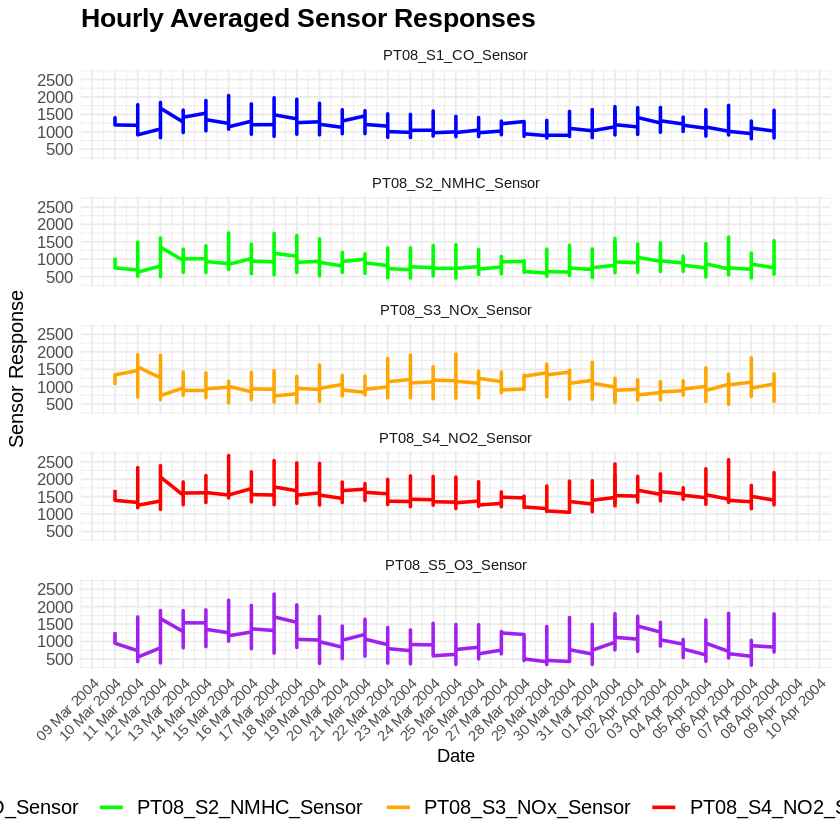

In [34]:
set.seed(1111)

print("Plot 1: Hourly Averaged Sensor Responses")


# Pivot the data to long format for ggplot
air_quality_melted <- pivot_longer(air_quality_cleaned, 
                                   cols = starts_with("PT08_S"), 
                                   names_to = "Sensor",
                                   values_to = "Sensor_Response")

# Create the plot
air_quality_sensor_plots <- ggplot(air_quality_melted, aes(x = Date, y = Sensor_Response, color = Sensor)) +
  geom_line(size = 1) +
  labs(title = "Hourly Averaged Sensor Responses",
       x = "Date",
       y = "Sensor Response",
       color = "Sensor") +
  scale_color_manual(values = c("PT08_S1_CO_Sensor" = "blue", "PT08_S2_NMHC_Sensor" = "green", 
                                "PT08_S3_NOx_Sensor" = "orange", "PT08_S4_NO2_Sensor" = "red",
                                "PT08_S5_O3_Sensor" = "purple")) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text.y = element_text(size = 10),  # Adjust the size of y-axis labels
    axis.title.y = element_text(size = 12),  # Adjust the size of y-axis title
    plot.title = element_text(size = 16, face = "bold"),
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 14),
    legend.position = "bottom"
  ) +
  scale_x_date(date_breaks = "1 day", date_labels = "%d %b %Y") +
  scale_y_continuous(breaks = seq(0, 2500, by = 500))  # Adjust the y-axis tick marks

# Separate plots for each sensor using facets
air_quality_sensor_plots_faceted <- air_quality_sensor_plots + 
  facet_wrap(~ Sensor, nrow = 5)

air_quality_sensor_plots_faceted

[1] "Plot 2: Box Plot of Hourly Averaged Sensor Responses"


Warning message:
“Removed 135 rows containing non-finite values (stat_boxplot).”


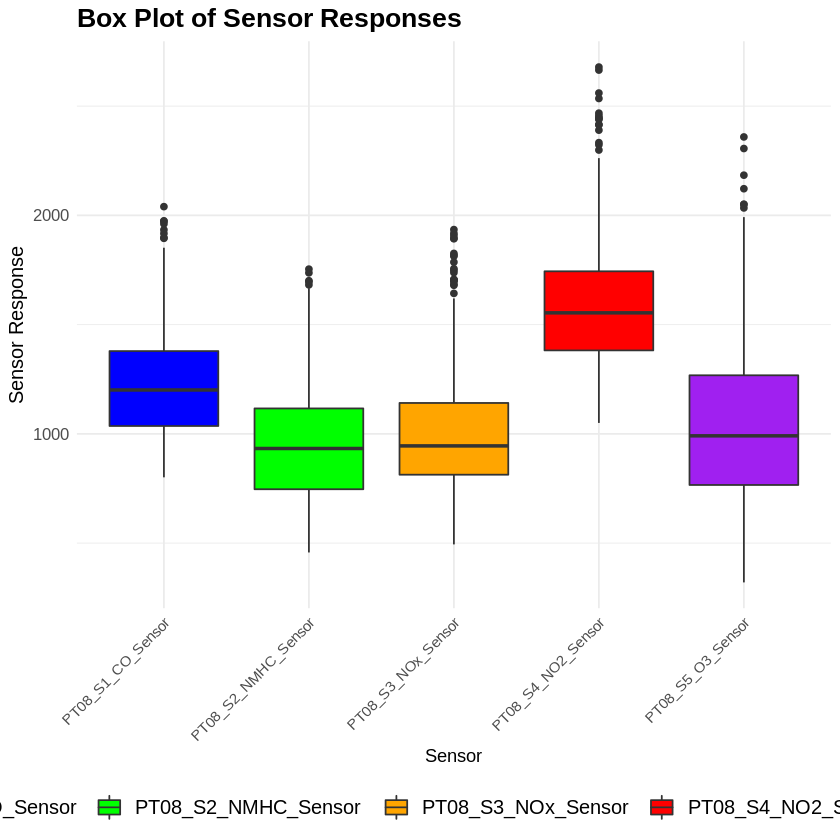

In [28]:
set.seed(1111)

print("Plot 2: Box Plot of Hourly Averaged Sensor Responses")


# Create the box plot
air_quality_boxplot <- ggplot(air_quality_melted, aes(x = Sensor, y = Sensor_Response, fill = Sensor)) +
  geom_boxplot() +
  labs(title = "Box Plot of Sensor Responses",
       x = "Sensor",
       y = "Sensor Response",
       fill = "Sensor") +
  scale_fill_manual(values = c("PT08_S1_CO_Sensor" = "blue", "PT08_S2_NMHC_Sensor" = "green", 
                               "PT08_S3_NOx_Sensor" = "orange", "PT08_S4_NO2_Sensor" = "red",
                               "PT08_S5_O3_Sensor" = "purple")) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text.y = element_text(size = 10),  # Adjust the size of y-axis labels
    axis.title.y = element_text(size = 12),  # Adjust the size of y-axis title
    plot.title = element_text(size = 16, face = "bold"),
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 14),
    legend.position = "bottom"
  )

# Print the box plot
print(air_quality_boxplot)

In [29]:
set.seed(1111)


print("Table 1: Summary Statistics of Each Sensor Responses")

# Group the data by "Sensor" and calculate summary statistics
sensor_summary <- air_quality_melted %>%
  group_by(Sensor) %>%
  summarize(
    Mean_Sensor_Response = mean(Sensor_Response, na.rm = TRUE),
    Median_Sensor_Response = median(Sensor_Response, na.rm = TRUE),
    SD_Sensor_Response = sd(Sensor_Response, na.rm = TRUE),
    Min_Sensor_Response = min(Sensor_Response, na.rm = TRUE),
    Max_Sensor_Response = max(Sensor_Response, na.rm = TRUE)
  )

# Print the tibble
sensor_summary

[1] "Table 1: Summary Statistics of Each Sensor Responses"


Sensor,Mean_Sensor_Response,Median_Sensor_Response,SD_Sensor_Response,Min_Sensor_Response,Max_Sensor_Response
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PT08_S1_CO_Sensor,1221.1702,1201,232.5613,801,2040
PT08_S2_NMHC_Sensor,942.3305,933,255.7705,457,1754
PT08_S3_NOx_Sensor,997.3534,945,262.2223,494,1935
PT08_S4_NO2_Sensor,1586.6123,1554,272.2869,1050,2679
PT08_S5_O3_Sensor,1022.8999,991,367.6864,320,2359


### 2.5. Computing our estimates

In [30]:
set.seed(1111)


air_quality_cleaned <- air_quality_cleaned %>%
  mutate(Time = as.POSIXct(Time, format = "%H:%M:%S"),  # Convert Time to POSIXct format
         Day_Night = ifelse(hour(Time) < 12, "Day", "Night"),  # Create Day_Night column
         AQI_Estimator = rowMeans(select(., PT08_S1_CO_Sensor,PT08_S2_NMHC_Sensor,PT08_S3_NOx_Sensor, PT08_S4_NO2_Sensor, PT08_S5_O3_Sensor),
                                       na.rm = TRUE))  # Calculate mean of sensor values

# Select only the Day_Night column and the new Mean_Sensor_Values column
air_quality_final <- air_quality_cleaned %>%
  select(Day_Night, AQI_Estimator) |>
  filter(!is.na(AQI_Estimator))

head(air_quality_final)

,Day_Night,AQI_Estimator
,<chr>,<dbl>
1,Night,1284.4
2,Night,1190.4
3,Night,1222.0
4,Night,1240.6
5,Night,1182.6
6,Night,1125.2


[1] "Plot 3: Box Plot of AQI Estimator Values by Day and Night"


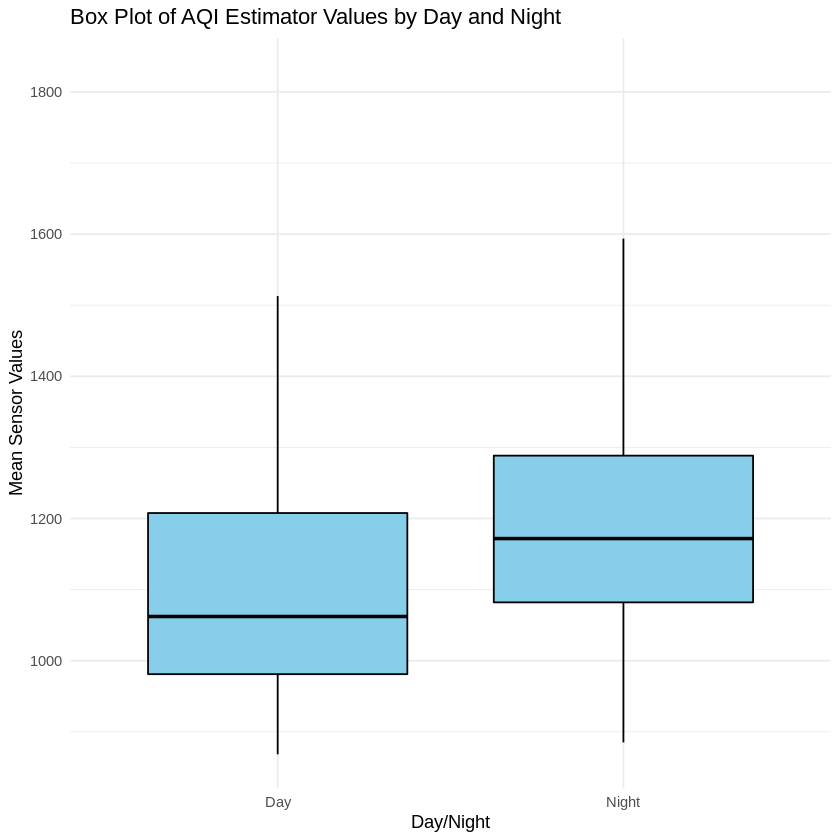

In [31]:
set.seed(1111)

print("Plot 3: Box Plot of AQI Estimator Values by Day and Night")

# Create a box plot
boxplot <- ggplot(air_quality_final, aes(x = Day_Night, y = AQI_Estimator)) +
  geom_boxplot(fill = "skyblue", color = "black", outlier.shape = NA) +
  labs(title = "Box Plot of AQI Estimator Values by Day and Night",
       x = "Day/Night",
       y = "Mean Sensor Values") +
  theme_minimal()

print(boxplot)

In [32]:
set.seed(1111)


print("Table 2: Summary Statistics of AQI Estimator by Day and Night")


# Group the data by "Day_Night" and calculate the mean, median, standard deviation, and quartiles of "AQI_Estimator"
stats_by_day_night <- air_quality_final %>%
  group_by(Day_Night) %>%
  summarize(
    AQI_Estimator_Mean = mean(AQI_Estimator, na.rm = TRUE),
    AQI_Estimator_Median = median(AQI_Estimator, na.rm = TRUE),
    AQI_Estimator_SD = sd(AQI_Estimator, na.rm = TRUE),
    AQI_Estimator_Q1 = quantile(AQI_Estimator, 0.25, na.rm = TRUE),
    AQI_Estimator_Q3 = quantile(AQI_Estimator, 0.75, na.rm = TRUE)
  )

# Print the tibble
stats_by_day_night

[1] "Table 2: Summary Statistics of AQI Estimator by Day and Night"


Day_Night,AQI_Estimator_Mean,AQI_Estimator_Median,AQI_Estimator_SD,AQI_Estimator_Q1,AQI_Estimator_Q3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Day,1113.375,1062.2,175.2413,981.1,1207.7
Night,1194.423,1171.8,164.2705,1082.1,1288.4


[1] "Plot 4: Distribution of AQI Estimator for Day and Night"


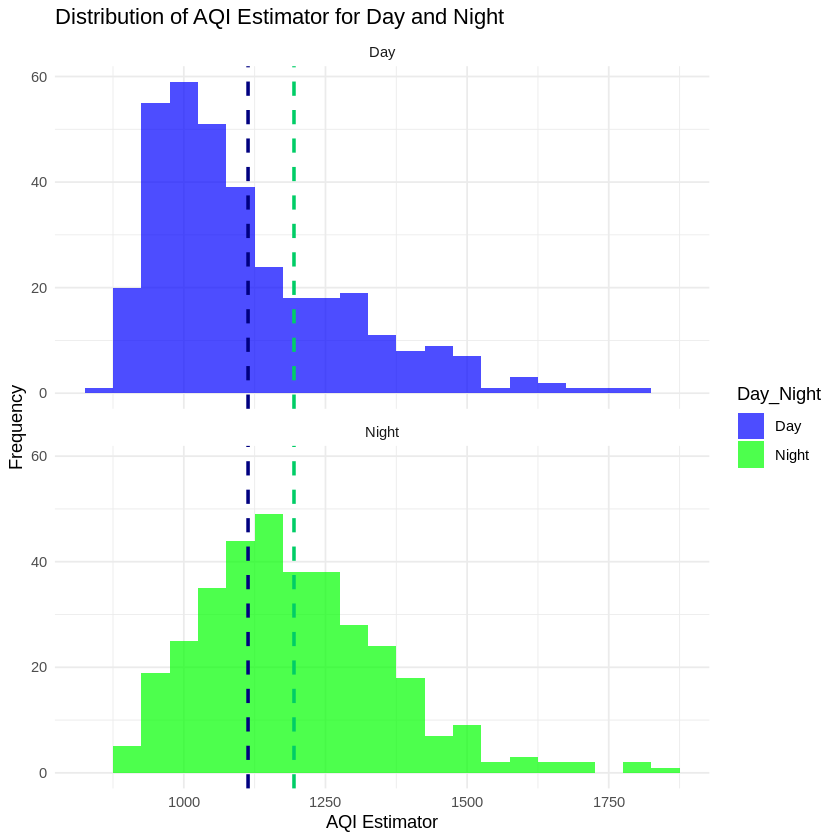

In [33]:
set.seed(1111)

# Calculate the means for Day and Night
mean_day <- mean(air_quality_final$AQI_Estimator[air_quality_final$Day_Night == "Day"], na.rm = TRUE)
mean_night <- mean(air_quality_final$AQI_Estimator[air_quality_final$Day_Night == "Night"], na.rm = TRUE)

print("Plot 4: Distribution of AQI Estimator for Day and Night")

## Plot for the Distribution of AQI Estimator for Day and Night
ggplot(air_quality_final, aes(x = AQI_Estimator, fill = Day_Night)) +
  geom_histogram(binwidth = 50, position = "dodge", alpha = 0.7) +
  geom_vline(xintercept = mean_day, linetype = "dashed", color = "navyblue", size = 1) +
  geom_vline(xintercept = mean_night, linetype = "dashed", color = "springgreen3", size = 1) +
  labs(title = "Distribution of AQI Estimator for Day and Night",
       x = "AQI Estimator",
       y = "Frequency") +
  scale_x_continuous(breaks = seq(0, 2500, by = 250)) +
  scale_fill_manual(values = c("Day" = "blue", "Night" = "green")) +
  theme_minimal() +
  facet_wrap(~Day_Night, ncol = 1)

## 3. Methods: Plan

Our report can be considered trustworthy as it is diligently pre-processed from a reputable dataset from the UCI machine learning repository, with any missing entries removed to ensure reliable results presented as insightful plots and estimates. However, this may not be sufficient for stakeholders who require more rigorous evidence. So, we aim to complement the plots with hypothesis testing and confidence intervals to make inferences about the population parameters with a certain level of confidence.

We will conduct a **hypothesis test** to compare the average sensor response between mornings and nights. The null hypothesis (H<sub>0</sub>) would be that there is no significant difference in the mean sensor response during mornings and nights, while the alternative hypothesis (H<sub>A</sub>) would be that a significant difference exists.

We will also construct **confidence intervals** (using a confidence level of 95%) for the mean sensor response during mornings and nights separately, to obtain a range of plausible values for the population mean, providing a measure of uncertainty around our estimates.

We expect that, on average, the air quality is worse in the mornings. Based on previous research on the topic, the highest concentrations of different pollutants occur in the morning, likely due to traffic density, road dust or temperature inversions (Chen et al., 2015).

The finding of this research could have significant implications for urban planning and public health policies.
City authorities and environmental agencies can use this information to implement targeted interventions during specific times of the day to improve air quality and protect public health.

This could lead to further research on the long term health effects of exposure to poor air quality in cities: how does consistent exposure to poor air quality affect one’s long term health? Additionally, it may be interesting to explore the relationship between air quality and specific sources of pollution, such as vehicular emissions or industrial activities.

In conclusion, this comprehensive report aims to shed light on the average air quality in an Italian city during mornings and nights. By incorporating hypothesis testing and confidence intervals, we can provide more robust evidence to stakeholders, facilitating informed decision-making and potential policy changes for a healthier urban environment. The research findings could lead to further investigations and have a positive impact on public health and environmental management in the long run.

In [12]:
head(air_quality_final)

,Day_Night,AQI_Estimator
,<chr>,<dbl>
1,Night,1284.4
2,Night,1190.4
3,Night,1222.0
4,Night,1240.6
5,Night,1182.6
6,Night,1125.2


In [13]:
set.seed(1111)


# Subset the data into morning and night observations
morning_data <- air_quality_final %>%
  filter(Day_Night == "Day")

night_data <- air_quality_final %>%
  filter(Day_Night == "Night")


# Perform a two-sample t-test
t_test_result <- tidy(t.test(morning_data$AQI_Estimator, night_data$AQI_Estimator))

# Print the results
t_test_result


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-74.25533,1033.722,1107.978,-19.31765,1.694561e-81,8979.451,-81.79028,-66.72039,Welch Two Sample t-test,two.sided


In [19]:
# Calculate summary statistics for each Day_Night group
air_quality_summary <- 
  air_quality_final %>% 
  filter(!is.na(AQI_Estimator)) %>% 
  group_by(Day_Night) %>% 
  summarise(sample_mean = mean(AQI_Estimator), 
            sample_var = var(AQI_Estimator),
            sample_sd = sd(AQI_Estimator),
            n = n())

# Print the summary statistics
head(air_quality_summary)

# Calculate the t-statistic for the paired t-test
t_statistic <- 
  (air_quality_summary$sample_mean[2] - air_quality_summary$sample_mean[1]) /
  sqrt(air_quality_summary$sample_var[2] / air_quality_summary$n[2] +
       air_quality_summary$sample_var[1] / air_quality_summary$n[1])

# Print the calculated t-statistic
t_statistic

# Calculate the degrees of freedom approximation
df_approx <- air_quality_summary$n[1] + air_quality_summary$n[2] - 2

# Calculate the p-value using the cumulative distribution function (CDF) of the t-distribution
p_value <- 2 * pt(abs(t_statistic), df_approx, lower.tail = FALSE)

# Print the calculated p-value
p_value

Day_Night,sample_mean,sample_var,sample_sd,n
<chr>,<dbl>,<dbl>,<dbl>,<int>
Day,1033.722,32340.05,179.8334,4510
Night,1107.978,34077.62,184.6012,4481


[1] 19.31765

[1] 1.687928e-81

In [15]:
# Calculate the mean AQI_Estimator for each Day_Night group
obs_mean_aqi_diff <- 
    air_quality_final %>% 
    group_by(Day_Night) %>% 
    summarise(mean = mean(AQI_Estimator)) %>%

    # Pivot the data to have Day and Night mean AQI in separate columns
    pivot_wider(names_from = Day_Night, values_from = mean) %>%
    
    # Calculate the difference between Night and Day mean AQI
    transmute(diff = Night - Day) %>%
    
    # Extract the calculated differences into a vector
    pull(diff)

# Display the calculated differences
obs_mean_aqi_diff


[1] 74.25533

In [16]:
# Set the seed for reproducibility
set.seed(1111)

# Create a null model for AQI_Estimator based on Day_Night categories
null_model_aqi <- 
    air_quality_final %>% 
    
    # Define the formula for the null model
    specify(formula = AQI_Estimator ~ Day_Night) %>% 
    
    # Specify the null hypothesis as independence between variables
    hypothesize(null = "independence") %>% 
    
    # Generate permutations of the data
    generate(reps = 1000, type = "permute") %>% 
    
    # Calculate the statistic (difference in means) for each permutation
    calculate(stat = "diff in means", order = c("Night", "Day"))

# Display the first few rows of the calculated null model statistics
head(null_model_aqi)


replicate,stat
<int>,<dbl>
1,7.125906
2,2.148254
3,-4.330915
4,-4.473726
5,2.619041
6,-4.106599


Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


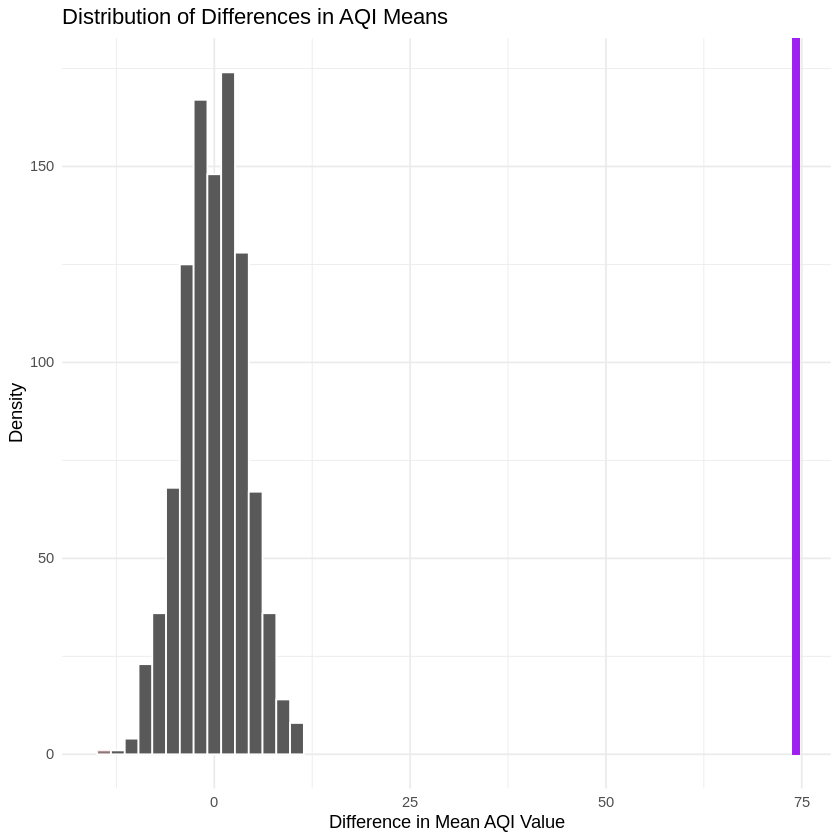

In [17]:
# Visualize the results of the null model for AQI differences
aqi_result_plot <- null_model_aqi %>%
    visualize() +
    theme_minimal() +                # Set a clean and minimal theme
    labs(
        title = "Distribution of Differences in AQI Means",
        x = "Difference in Mean AQI Value",
        y = "Density"
    ) +
    shade_p_value(
        obs_stat = obs_mean_aqi_diff,
        direction = "both",
        color = "purple",             # Choose a distinct color for the shaded region
        alpha = 0.3                   # Adjust transparency of the shaded region
    )

# Display the improved plot
aqi_result_plot


# Calculate the p-value using the bootstrap distribution of null model statistics
p_value_bootstrap <- null_model_aqi %>%
    get_p_value(obs_stat = obs_mean_aqi_diff, direction = "both")

# Display the calculated p-value
p_value_bootstrap


## 4. References

Chen, W., Tang, H., & Zhao, H. (2015). Diurnal, weekly and monthly spatial variations of air pollutants and air  quality of Beijing. Atmospheric Environment, 119, 21-34. https://doi.org/10.1016/j.atmosenv.2015.08.040

Lemeš, S. (2018). Air Quality Index (AQI) - Comparative Study and Assessment of an Appropriate Model for B&H. 12th Scientific/Research Symposium with International Participation. 

Trozzi, C.,  Vaccaro, R., & Crocetti, S. (1999). Air quality index and its use in Italy’s management plans. Science of the Total Environment. 235(1-3),387-389. https://doi.org/10.1016/S0048-9697(99)00242-9
